# TODO:

- Check the behaviour of the model for images with different extensions : for png : operands could not be broadcast together with shapes (4,400,400) (3,1,1) 
- Error handling for the model
- Error handling for loading the images
- Error handling for the URLs themselves
- Separate utility functions (?)
- Download example images and comment


- Integrate with the platform
- Write a good readme.md

### Known Issues:

- Crops central part of rectangular images to use as input
- No user image upload yet

### Done:

- Now allows .png images
- Stop saving snapshots (but keep the code nearby to show the changes if UI allows)
- Specify number of epochs : done by specifying (specially) optimization_rounds but also optimization_iterations
- Allow images from URL : done
- Close / Delete temporary images : done
- Check the behaviour of the model for images smaller than SIZE : they're simply resized 

# README.md

## Neural Artistic Style Tranfer

This service uses convolutional neural networks to transfer the style of a picture to another.

Specifically, we're using a VGG model pre-trained on ImageNet data (available at https://cntk.ai/jup/models/vgg16_weights.bin ) to transfer the style of a _style image_ to a _content image_. 

Basic Usage:
JSON or GRPC with only content / style images

The following example images are already available at the current directory to be used as either content or style:
- 'van_gogh.jpg'
- 'blabla'

Optional Parameters:

- start_from_random (False): tells the algorithm to start from the content or from a randomly generated image;
- optimization_rounds (10): number of optimization rounds;
- optimization_iterations (20): number of optimization iterations per round;
- output_image_size (300): images passed as inputs will be converted to square images of this size. The larger the size, the longer the style transfering will take due to an increased number of operations.

# Libraries

In [111]:
from __future__ import print_function
import numpy as np
from scipy import optimize as opt
import cntk as C
from PIL import Image
import requests
import h5py
import os
from io import BytesIO
import errno
%matplotlib inline
import matplotlib.pyplot as plt

import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

## Downloads (First RUN)

#### Download Model

In [10]:
def download(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as handle:
        for data in response.iter_content(chunk_size=2**20):
            if data: handle.write(data)

path = 'dnn_models/vgg16_weights.bin'
url = 'https://cntk.ai/jup/models/vgg16_weights.bin'
print("Download the VGG model(~500Mb)? (y/n)")
opt = input()
if opt == 'y':
    # We check for the model locally
    if not os.path.exists(path):
        print('downloading VGG model (~0.5GB)')
        download(url, path)
        print('loaded VGG model')

Download the VGG model(~500Mb)? (y/n)
n


#### Download Example Images

In [ ]:
links = {}

links['mona_lisa.jpg'] = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'
links['the_starry_night.jpg'] = 'https://iheartintelligence.com/wp-content/uploads/2015/09/THE-STARRY-NIGHT.jpg'


links['modernism.jpg'] = 'http://www.kokuyocamlin.com/blog/wp-content/uploads/2018/04/32.jpg'
links['impressionism.jpg'] = 'http://www.kokuyocamlin.com/blog/wp-content/uploads/2018/04/31_crop.png'
links['abstract.jpg'] = 'http://www.kokuyocamlin.com/blog/wp-content/uploads/2018/04/28.jpg'
links['expressionism.jpg'] = 'http://www.kokuyocamlin.com/blog/wp-content/uploads/2018/04/30.jpg'
links['cubism.jpg'] = 'http://www.kokuyocamlin.com/blog/wp-content/uploads/2018/04/29.jpg'

links[''] = ''
links[''] = ''

# Class

In [130]:
def download(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as handle:
        for data in response.iter_content(chunk_size=2**20):
            if data: handle.write(data)
                
class style_transfer:
    """Transfers the style from one image to another."""
    
    
    def __init__(self):
        
        # Initializing parameters
        self.START_FROM_RANDOM = bool
        self.OPTIMIZATION_ROUNDS = int
        self.OPTIMIZATION_ITERATIONS = int
        self.SIZE = int
        
        self.SAVE_SNAPSHOTS = False
        
        self.CONTENT_WEIGHT = 5.0
        self.STYLE_WEIGHT = 1.0
        self.DECAY = 0.5
        
        self.MODEL_PATH = 'dnn_models/vgg16_weights.bin'
        TEMP_IMAGES = {}
        TEMP_IMAGES['content'] = 'content_temp.jpg'
        TEMP_IMAGES['style'] = 'style_temp.jpg'

        # Image shift parameters
        self.SHIFT = np.reshape([103.939, 116.779, 123.68], (3, 1, 1)).astype('f')
        
        # Loads the VGG network
        self.MODEL = self._load_model()
    
    def _load_model(self):
        """Loads the VGG network to perform style transfer."""
        # Checks if model is available.
        if not os.path.exists(self.MODEL_PATH):
            raise os.error("Unable to load pre-trained model: file not available. Download it from https://cntk.ai/jup/models/vgg16_weights.bin.")
        f = h5py.File(self.MODEL_PATH)
        layers = []
        for k in range(f.attrs['nb_layers']):
            g = f['layer_{}'.format(k)]
            n = g.attrs['nb_params']
            layers.append([g['param_{}'.format(p)][:] for p in range(n)])
        f.close()
        print('Loaded VGG model.')
        return layers
    
    def _vggblock(self, x, arrays, layer_map, name):
        """A convolutional layer in the VGG network."""
        f = arrays[0]
        b = arrays[1]
        k = C.constant(value=f)
        t = C.constant(value=np.reshape(b, (-1, 1, 1)))
        y = C.relu(C.convolution(k, x, auto_padding=[False, True, True]) + t)
        layer_map[name] = y
        return y
    
    def _vggpool(self, x):
        """A pooling layer in the VGG network."""
        return C.pooling(x, C.AVG_POOLING, (2, 2), (2, 2))
    
    def _model(self, x):
        """Build the graph for the VGG network (excluding fully connected layers)."""
        model_layers = {}
        def convolutional(z): return len(z) == 2 and len(z[0].shape) == 4
        conv = [layer for layer in self.MODEL if convolutional(layer)]
        cnt = 0
        num_convs = {1: 2, 2: 2, 3: 3, 4: 3, 5: 3}
        for outer in range(1,6):
            for inner in range(num_convs[outer]):
                x = self._vggblock(x, conv[cnt], model_layers, 'conv%d_%d' % (outer, 1+inner))
                cnt += 1
            x = self._vggpool(x)

        return x, C.combine([model_layers[k] for k in sorted(model_layers.keys())])
    
    def _flatten(self, x):
        """Flattens an array."""
        assert len(x.shape) >= 3
        return C.reshape(x, (x.shape[-3], x.shape[-2] * x.shape[-1]))

    def _gram(self, x):
        """Calculates the gram matrix (i.e. style matrix) for a layer."""
        features = C.minus(self._flatten(x), C.reduce_mean(x))
        return C.times_transpose(features, features)

    def _npgram(self, x):
        """Calculates the gram matrix (i.e. style matrix) for a layer using numpy."""
        features = np.reshape(x, (-1, x.shape[-2]*x.shape[-1])) - np.mean(x)
        return features.dot(features.T)

    def _style_loss(self, a, b):
        """Defines the style loss."""
        channels, x, y = a.shape
        assert x == y
        A = self._gram(a)
        B = self._npgram(b)
        return C.squared_error(A, B)/(channels**2 * x**4)
    
    def _content_loss(self, a, b):
        """Defines the content loss."""
        channels, x, y = a.shape
        return C.squared_error(a, b)/(channels*x*y)

    def _total_variation_loss(self, x):
        """Defines the total variation loss."""
        xx = C.reshape(x, (1,)+x.shape)
        delta = np.array([-1, 1], dtype=np.float32)
        kh = C.constant(value=delta.reshape(1, 1, 1, 1, 2))
        kv = C.constant(value=delta.reshape(1, 1, 1, 2, 1))
        dh = C.convolution(kh, xx, auto_padding=[False])
        dv = C.convolution(kv, xx, auto_padding=[False])
        avg = 0.5 * (C.reduce_mean(C.square(dv)) + C.reduce_mean(C.square(dh)))
        return avg

    def _save_image(self, img, path):
        """Saves an image in the given path."""
        sanitized_img = np.maximum(0, np.minimum(255, img + self.SHIFT))
        pic = Image.fromarray(np.uint8(np.transpose(sanitized_img, (1, 2, 0))))
        pic.save(path)
    
    def _ordered_outputs(self, f, binding):
        """Orders outputs."""
        _, output_dict = f.forward(binding, f.outputs)
        return [np.squeeze(output_dict[out]) for out in f.outputs]
    
    def _vec2img(self, x):
        """Utility to convert a vector to an image."""
        d = np.round(np.sqrt(x.size / 3)).astype('i')
        return np.reshape(x.astype(np.float32), (3, d, d))

    def _img2vec(self, img):
        """Utility to convert an image to a vector."""
        return img.flatten().astype(np.float64)
    
    def _value_and_grads(self, f, binding):
        """Utility to compute the value and the gradient of f at a particular place defined by binding."""
        if len(f.outputs) != 1:
            raise ValueError('function must return a single tensor')
        df, valdict = f.forward(binding, [f.output], set([f.output]))
        value = list(valdict.values())[0]
        grads = f.backward(df, {f.output: np.ones_like(value)}, set(binding.keys()))
        return value, grads

    def _objfun(self, x, loss):
        """The objective function."""
        y = self._vec2img(x)
        v, g = self._value_and_grads(loss, {loss.arguments[0]: [[y]]})
        v = np.reshape(v, (1,))
        g = self._img2vec(list(g.values())[0])
        return v, g
    
    def _optimize(self, loss, x0):
        """The optimization procedure."""
        bounds = [(-np.min(self.SHIFT), 255-np.max(self.SHIFT))]*x0.size
        for i in range(self.OPTIMIZATION_ROUNDS):
            s = opt.minimize(self._objfun, self._img2vec(x0), args=(loss,), method='L-BFGS-B', 
                             bounds=bounds, options={'maxiter': self.OPTIMIZATION_ITERATIONS}, jac=True)
            print('objective : %s' % s.fun[0])
            x0 = self._vec2img(s.x)
            # Saves a snapshot of the output for every optimization round (OPTIMIZATION_ROUNDS)
            if self.SAVE_SNAPSHOTS:
                path = 'output_%d.jpg' % i
                self._save_image(x0, path)
        return x0
    
    def _load_image(self, path):
        """Loads an image from the given path."""
        with Image.open(path) as pic:

            # Checks if image is PNG, convert to JPG is needed
            if pic.format == 'PNG':
                with BytesIO() as f:
                    pic.save(f, format='JPEG')
                    f.seek(0)
                    pic = Image.open(f)
                    hw = pic.size[0] / 2
                    hh = pic.size[1] / 2
                    mh = min(hw,hh)
                    cropped = pic.crop((hw - mh, hh - mh, hw + mh, hh + mh))
                    array = np.array(cropped.resize((self.SIZE, self.SIZE), Image.BICUBIC), dtype=np.float32)
                    return np.ascontiguousarray(np.transpose(array, (2,0,1))) - self.SHIFT
            else:
                hw = pic.size[0] / 2
                hh = pic.size[1] / 2
                mh = min(hw,hh)
                cropped = pic.crop((hw - mh, hh - mh, hw + mh, hh + mh))
                array = np.array(cropped.resize((self.SIZE, self.SIZE), Image.BICUBIC), dtype=np.float32)
            return np.ascontiguousarray(np.transpose(array, (2,0,1))) - self.SHIFT

    def _load_images(self, content_path, style_path):
        """Loads images or download them if they are not available locally."""
        content_img = content_path
        style_img = style_path
        if not os.path.exists(content_path):
            download('%s' % content_path, TEMP_IMAGES['content'])
            content_img = TEMP_IMAGES['content']
        if not os.path.exists(style_path):
            download('%s' % style_path, TEMP_IMAGES['style'])
            style_img = TEMP_IMAGES['style']
        # Load the images
        content = self._load_image(content_img)
        style   = self._load_image(style_img)
        
        return content, style
    
    def _push_images(self, content, style):
        """Push the images through the VGG network """
        
        # First define the input and the output
        y = C.input_variable((3, self.SIZE, self.SIZE), needs_gradient=True)
        z, intermediate_layers = self._model(y)
        # Now get the activations for the two images
        content_activations = self._ordered_outputs(intermediate_layers, {y: [[content]]})
        style_activations = self._ordered_outputs(intermediate_layers, {y: [[style]]})
        style_output = np.squeeze(z.eval({y: [[style]]}))

        # Finally define the loss
        n = len(content_activations)
        total = (1 - self.DECAY ** (n+1)) / (1 - self.DECAY) # makes sure that changing the decay does not affect the magnitude of content/style
        loss = (1.0/total * self.CONTENT_WEIGHT * self._content_loss(y, content) 
                 + 1.0/total * self.STYLE_WEIGHT * self._style_loss(z, style_output) 
                 + self._total_variation_loss(y))

        for i in range(n):
            loss = (loss 
                + self.DECAY ** (i+1) / total * self.CONTENT_WEIGHT * self._content_loss(intermediate_layers.outputs[i], content_activations[i])
                + self.DECAY ** (n-i) / total * self.STYLE_WEIGHT * self._style_loss(intermediate_layers.outputs[i], style_activations[i]))
        return loss

    def _clear_images(self):
        """Deletes temporary image files."""
        # Deletes temporary images
        for img in list(TEMP_IMAGES.values()):
            try:
                os.remove(img)
            except OSError as e: # this would be "except OSError, e:" before Python 2.6
                if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
                    raise # re-raise exception if a different error occurred
    
    def print_image(self, img):
        """Prints the image on the screen."""
        plt.imshow(np.asarray(np.transpose(img + self.SHIFT, (1, 2, 0)), dtype=np.uint8))
    
    def transfer_style(self, content_image_path, 
                       style_image_path,
                       start_from_random = False, 
                       optimization_rounds = 10,
                       optimization_iterations = 20,
                       output_image_size = 300):
        """Transfers the style from a style image to a content image."""
        
        self.START_FROM_RANDOM = start_from_random
        self.OPTIMIZATION_ROUNDS = optimization_rounds
        self.OPTIMIZATION_ITERATIONS = optimization_iterations
        self.SIZE = output_image_size
        
        # Loads images
        content_image, style_image = self._load_images(content_image_path, style_image_path)
        
        # Transfers the style
        loss = self._push_images(content_image, style_image)
        np.random.seed(98052)
        if self.START_FROM_RANDOM:
            x0 = np.random.randn(3, self.SIZE, self.SIZE).astype(np.float32)
        else:
            x0 = content_image
        output_image = self._optimize(loss, x0)
        
        # Closes images
        self._clear_images()
        
        return output_image

# Calls

In [131]:
#style_path = 'temp_img.jpg'
content_path = '../Shared/Ramon_Duraes.jpg'
#content_path = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQI8fXsIvjj7pnHmaIOL0wezOhIAHMtz5Ip39ZaJ-y8W2wMeQ0c'
style_path = 'https://abrilsuperinteressante.files.wordpress.com/2016/10/super_imgsuper_mario_bros-_e_um_jogo_bem_mais_dificil_do_que_voce_imaginava.png'
#style_path = 'https://amazon.clikpic.com/SKershaw/images/mosaic_school_flower_Sue_Kershaw.JPG'
#content_path = 'https://www.grammy.com/sites/com/files/styles/image_landscape_hero/public/beyonce-hero-487073444_copy.jpg'

st = style_transfer()

Loaded VGG model.


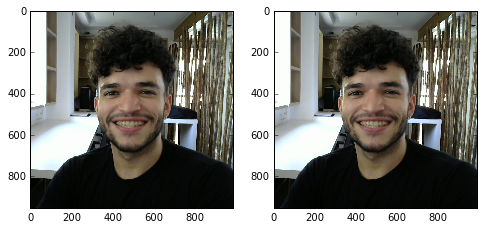

In [132]:
from PIL import Image 
from matplotlib.pyplot import imshow

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1

content_temp = Image.open(content_path, 'r')
#style_temp = Image.open(cStringIO.StringIO(urllib.urlopen(style_path).read()), 'r')

img = np.random.randint(10, size=(h,w))
fig.add_subplot(rows, columns, 1)
plt.imshow(np.asarray(content_temp))
fig.add_subplot(rows, columns, 2)
plt.imshow(np.asarray(content_temp))
plt.show()

In [135]:
%%time
output_image = st.transfer_style(content_image_path = content_path, 
                                 style_image_path = style_path, 
                                 start_from_random = False, 
                                 optimization_rounds = 4,
                                 optimization_iterations = 15,
                                 output_image_size = 400)

objective : 4.04387e+06
objective : 2.93436e+06
objective : 2.35074e+06
objective : 1.99922e+06
CPU times: user 33.1 s, sys: 34.8 s, total: 1min 7s
Wall time: 55.6 s


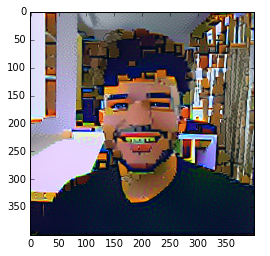

In [136]:
st.print_image(output_image)

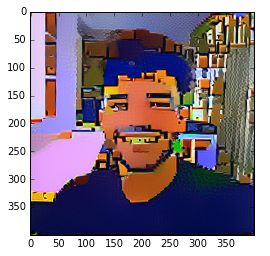

In [119]:
st.print_image(output_image)

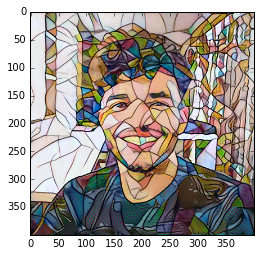

In [56]:
st.print_image(output_image)

___

# DRAFT

json_rpc vai sair! -> usar grpc, protobuf

diretorio da dapp tem UIs customizadas

URL Validation Test

In [ ]:
try:
    # python2
    from urlparse import urlparse
except:
    # python3
    from urllib.parse import urlparse

a = 'http://www.cwi.nl:80/%7Eguido/Python.html'
b = '/data/Python.html'
c = 532
d = u'dkakasdkjdjakdjadjfalskdjfalk'

def uri_validator(x):
    try:
        result = urlparse(x)
        return result.scheme and result.netloc and result.path
    except:
        return False

print(uri_validator(a))
print(uri_validator(b))
print(uri_validator(c))
print(uri_validator(d))

In [19]:
from PIL import Image 
from matplotlib.pyplot import imshow

content_temp = Image.open(content_path, 'r')
imshow(np.asarray(content_temp))

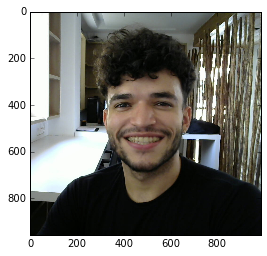

In [20]:
content_temp = Image.open(content_path, 'r')
imshow(np.asarray(content_temp))

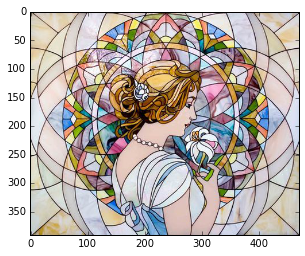

In [49]:
temp_path = "https://github.com/pytorch/examples/blob/master/fast_neural_style/images/style-images/mosaic.jpg?raw=true"
filename = "temp_img.jpg"

response = requests.get(temp_path, stream=True)
with open(filename, 'wb') as handle:
    for data in response.iter_content(chunk_size=2**20):
        if data: 
            handle.write(data)
        else: 
            raise os.error("No image found!")

temp_image = Image.open(filename)
imshow(np.asarray(temp_image))

In [45]:
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

In [46]:
url = "http://www.mosaic-tile-design.com/images/mosaic-mar-tree-lg.jpg"
try:
    urlretrieve(url, os.path.join(out_dir, normalize(url)))
except Exception as e :
    print ("Exception|",e,"|",url)

Exception| name 'out_dir' is not defined | http://www.mosaic-tile-design.com/images/mosaic-mar-tree-lg.jpg


In [86]:
!rm output_*

In [87]:
!ls

StyleTransferScript.ipynb  models


In [ ]:
def download(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as handle:
        for data in response.iter_content(chunk_size=2**20):
            if data: handle.write(data)

___

___

___

In [ ]:
# Image conversion draft]
#
            from PIL import Image
            im = Image.open("Ba_b_do8mag_c6_big.png")
            rgb_im = im.convert('RGB')
            rgb_im.save('colors.jpg')
            #
            from PIL import Image
            from io import BytesIO

            ima=Image.open("img.png")

            with BytesIO() as f:
               ima.save(f, format='JPEG')
               f.seek(0)
               ima_jpg = Image.open(f)
            #

!jupyter nbconvert --to script config_template.ipynb